# Explicit Euler 
Explicit Euler's method is given by
$$u_{ij}^{n+1} = (1 - 4\mu)u_{i,j}^{n} + \mu (u_{i+1,j}^{n}+u_{i-1,j}^{n}+u_{i,j-1}^{n}+u_{i,j+1}^{n})+2 k t^{n}(1+\pi^2t^n)\sin{\pi x_i}\sin{\pi y_j}$$
Write it in matrix form: 
$$u^{n+1} = (I + \mu A)u^{n} + kf^n$$ 
where 
- `A` is the second order finite difference matrix for 2D Laplacian with Dirichlet boundary conditions,
- $\mu = k/h^2$,
- $k$ is the time step size,
- $h$ is the grid spacing,
- $f^n = f(t^n, u^n)$.

In [20]:
import numpy as np
from bvp import * 

# initializations
space_domain = ((0, 1), (0, 1))
time_domain = (0, 1)
initial_condition = lambda x, y: 0
boundary_condition = 'dirichlet'
heat_source = lambda t, x, y: 2*t*(1 + np.pi**2 * t) * np.sin(np.pi * x) * np.sin(np.pi * y)
h = .1 # grid spacing

In [21]:
# expected solution 
u = lambda t, x, y: t**2 * np.sin(np.pi * x) * np.sin(np.pi * y)

# create meshgrid for expected solution
x_mesh, y_mesh = np.meshgrid(*[np.linspace(dom[0] + h, dom[1] - h, int((dom[1] - dom[0]) / h - 1)) for dom in space_domain], indexing='ij')

# compute expected solution at the end time
expected_sol = u(time_domain[1], x_mesh, y_mesh)

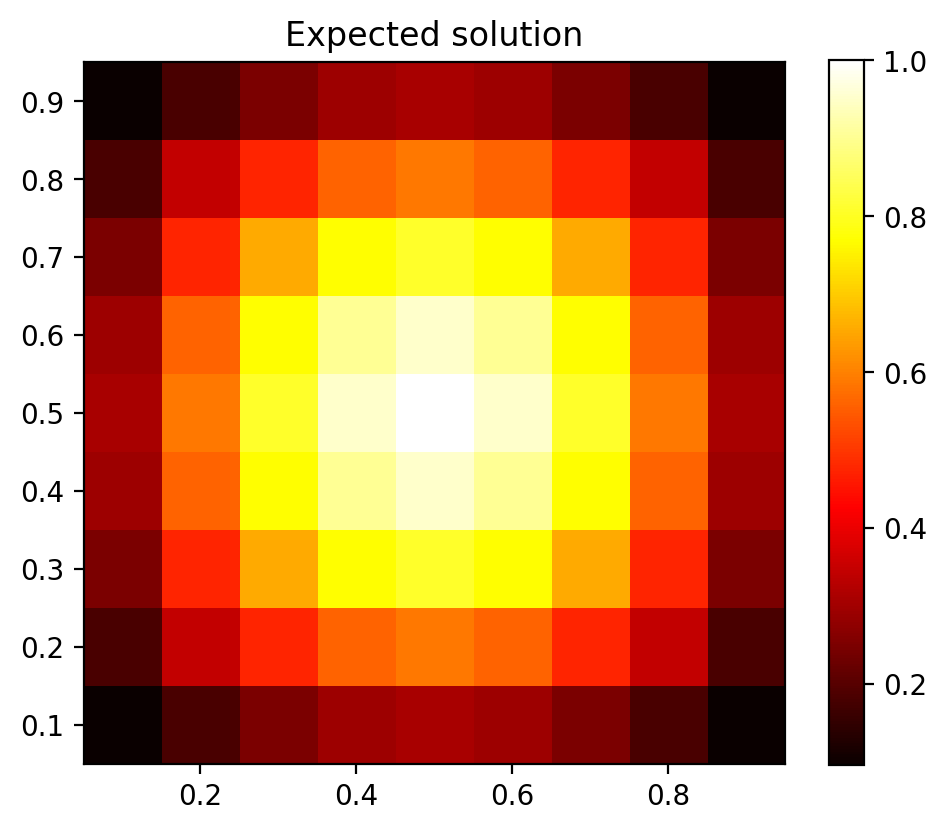

In [22]:
import matplotlib.pyplot as plt

extent = []
for i in range(len(space_domain)):
    extent.append(space_domain[i][0] + h/2)
    extent.append(space_domain[i][1] - h/2)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
ax.imshow(expected_sol, cmap='hot', interpolation='none', extent=extent)
ax.set_title('Expected solution')
fig.colorbar(ax.images[0], ax=ax, shrink=.75)

plt.tight_layout()

In [23]:
# define time steps
k_coarse, k_fine = 0.05, 0.002

In [24]:
# create 2D solver
solver = Diffusion2D(space_domain, h, initial_condition, boundary_condition, heat_source)

In [25]:
# solve using Forward Euler method
t_eval_coarse, sol_coarse = solver.solve(time_domain, k_coarse, method='euler')
l2_error_coarse = solver.calc_error(u)

t_eval_fine, sol_fine = solver.solve(time_domain, k_fine, method='euler')
l2_error_fine = solver.calc_error(u)

In [26]:
# calculate error with respect to expected solution 
grid_error_coarse = sol_coarse[-1] - expected_sol
grid_error_fine = sol_fine[-1] - expected_sol

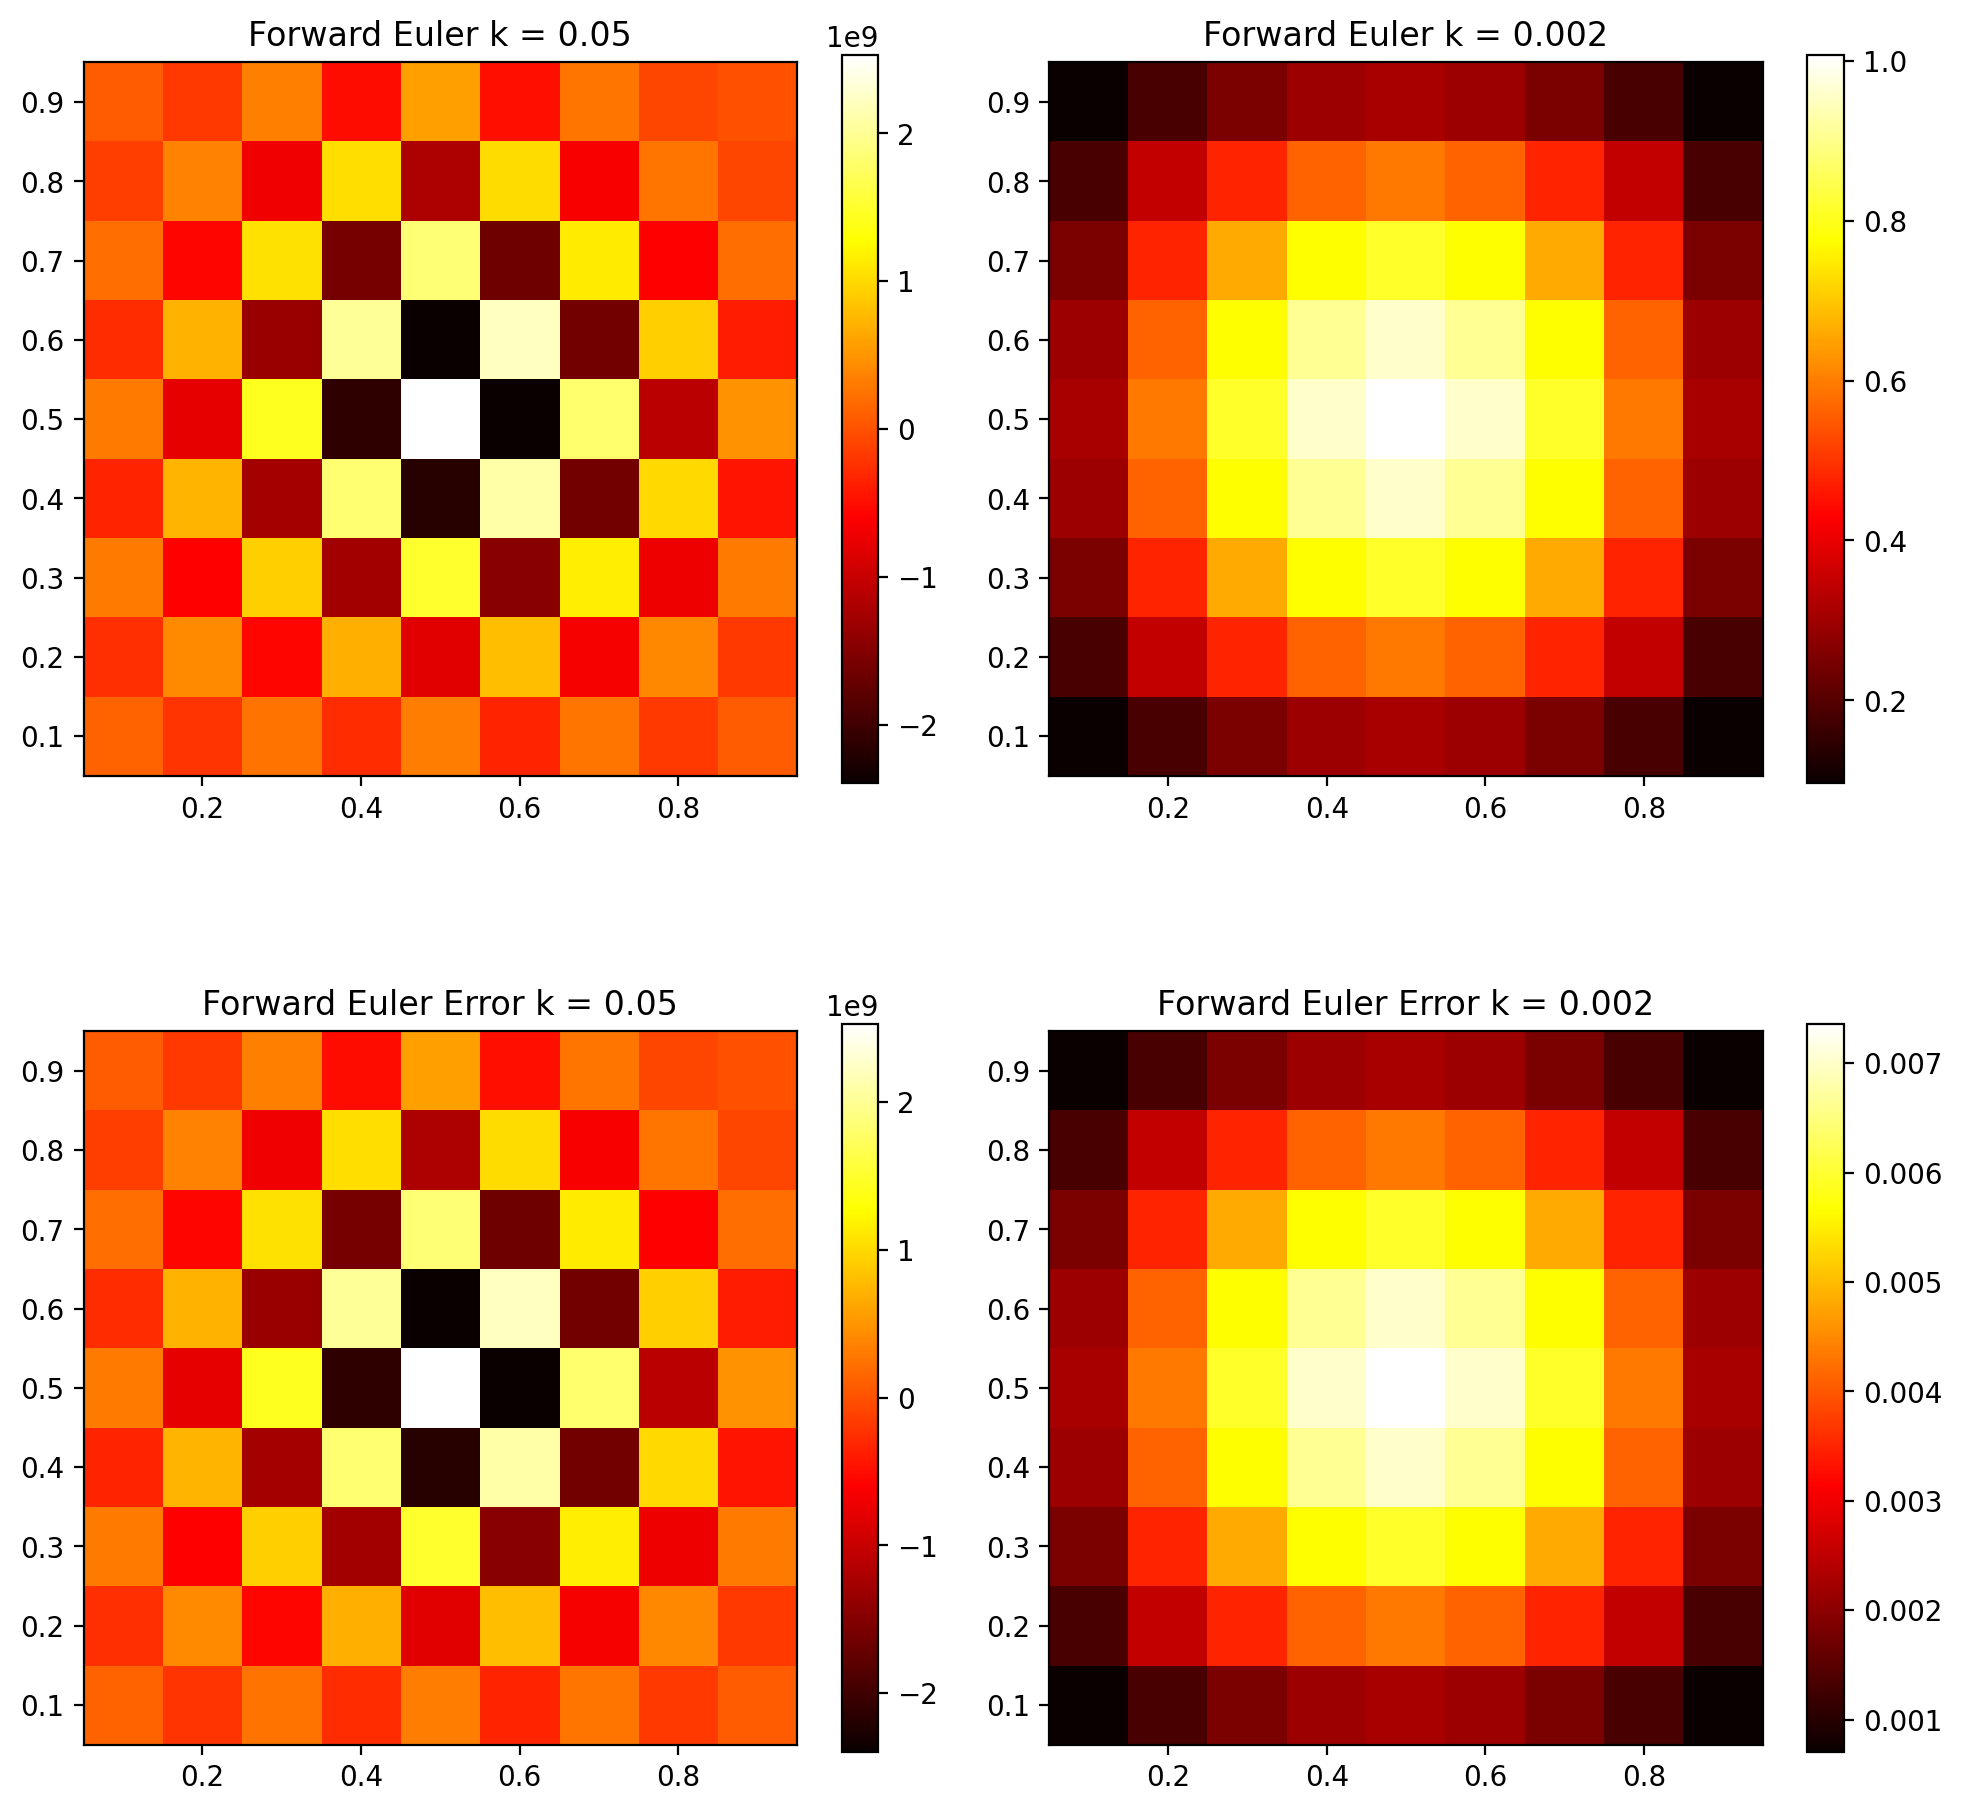

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)

im_coarse = axs[0, 0].imshow(sol_coarse[-1], cmap='hot', interpolation='none', extent=extent, origin='lower')
axs[0, 0].set_title(f'Forward Euler k = {k_coarse}')
fig.colorbar(axs[0, 0].images[0], ax=axs[0, 0], shrink=0.75)

im_fine = axs[0, 1].imshow(sol_fine[-1], cmap='hot', interpolation='none', extent=extent, origin='lower')
axs[0, 1].set_title(f'Forward Euler k = {k_fine}')
fig.colorbar(axs[0, 1].images[0], ax=axs[0, 1], shrink=0.75)

axs[1, 0].imshow(grid_error_coarse, cmap='hot', interpolation='none', extent=extent, origin='lower')
axs[1, 0].set_title(f'Forward Euler Error k = {k_coarse}')
fig.colorbar(axs[1, 0].images[0], ax=axs[1, 0], shrink=0.75)

axs[1, 1].imshow(grid_error_fine, cmap='hot', interpolation='none', extent=extent, origin='lower')
axs[1, 1].set_title(f'Forward Euler Error k = {k_fine}')
plt.colorbar(axs[1, 1].images[0], ax=axs[1, 1], shrink=0.75)

plt.tight_layout()

Text(0.5, 1.0, "Euler's method L2 Error at k = 0.05")

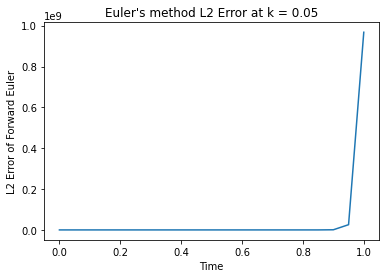

In [28]:
plt.plot(t_eval_coarse, l2_error_coarse, label=f'k = {k_coarse}')
plt.xlabel('Time')
plt.ylabel('L2 Error of Forward Euler')
plt.title('Euler\'s method L2 Error at k = {}'.format(k_coarse))

Text(0.5, 1.0, "Euler's method L2 Error at k = 0.002")

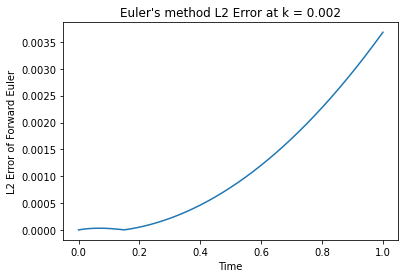

In [29]:
plt.plot(t_eval_fine, l2_error_fine, label=f'k = {k_fine}')
plt.xlabel('Time')
plt.ylabel('L2 Error of Forward Euler')
plt.title('Euler\'s method L2 Error at k = {}'.format(k_fine))

## Discussion
- `k=.05` case: Solution is instable because $\mu = k/h^2 = 5 > 1/2$. 
- `k=.002` case: Solution is stable because $\mu = k/h^2 = 0.2 < 1/2$. But the L-2 norm error grows over time. This is different from the situation without source term, in which the L-2 norm error decreases over time. L-infinity norm error also grows over time and reaches about `.007` at the end. 

# Trapezoidal Rule

The trapezoidal rule is given by 
$$u^{n+1} = (I - \mu/2 A)^{-1}(I + \mu/2 A)u^{n} + \frac{k}{2}(I - \mu/2 A)^{-1}(f^{n+1} + f^{n})$$
where 
- `A` is the second order finite difference matrix for the 2D Laplacian,
- $\mu = k/h^2$, 
- $k$ is the time step size,
- $h$ is the grid spacing,
- $f^{n} = f(t^{n}, u^{n})$. 

`A` is a sparse matrix in my code. I used `scipy.sparse.linalg.inv` to invert the matrix and solve the linear system.

In [30]:
# solve using Trapezoidal method
_, sol_coarse = solver.solve(time_domain, k_coarse, method='trapezoid')
l2_error_coarse = solver.calc_error(u)

time_list, sol_fine = solver.solve(time_domain, k_fine, method='trapezoid')
l2_error_fine = solver.calc_error(u)

In [31]:
# calculate error with respect to expected solution 
grid_error_coarse = sol_coarse[-1] - expected_sol
grid_error_fine = sol_fine[-1] - expected_sol

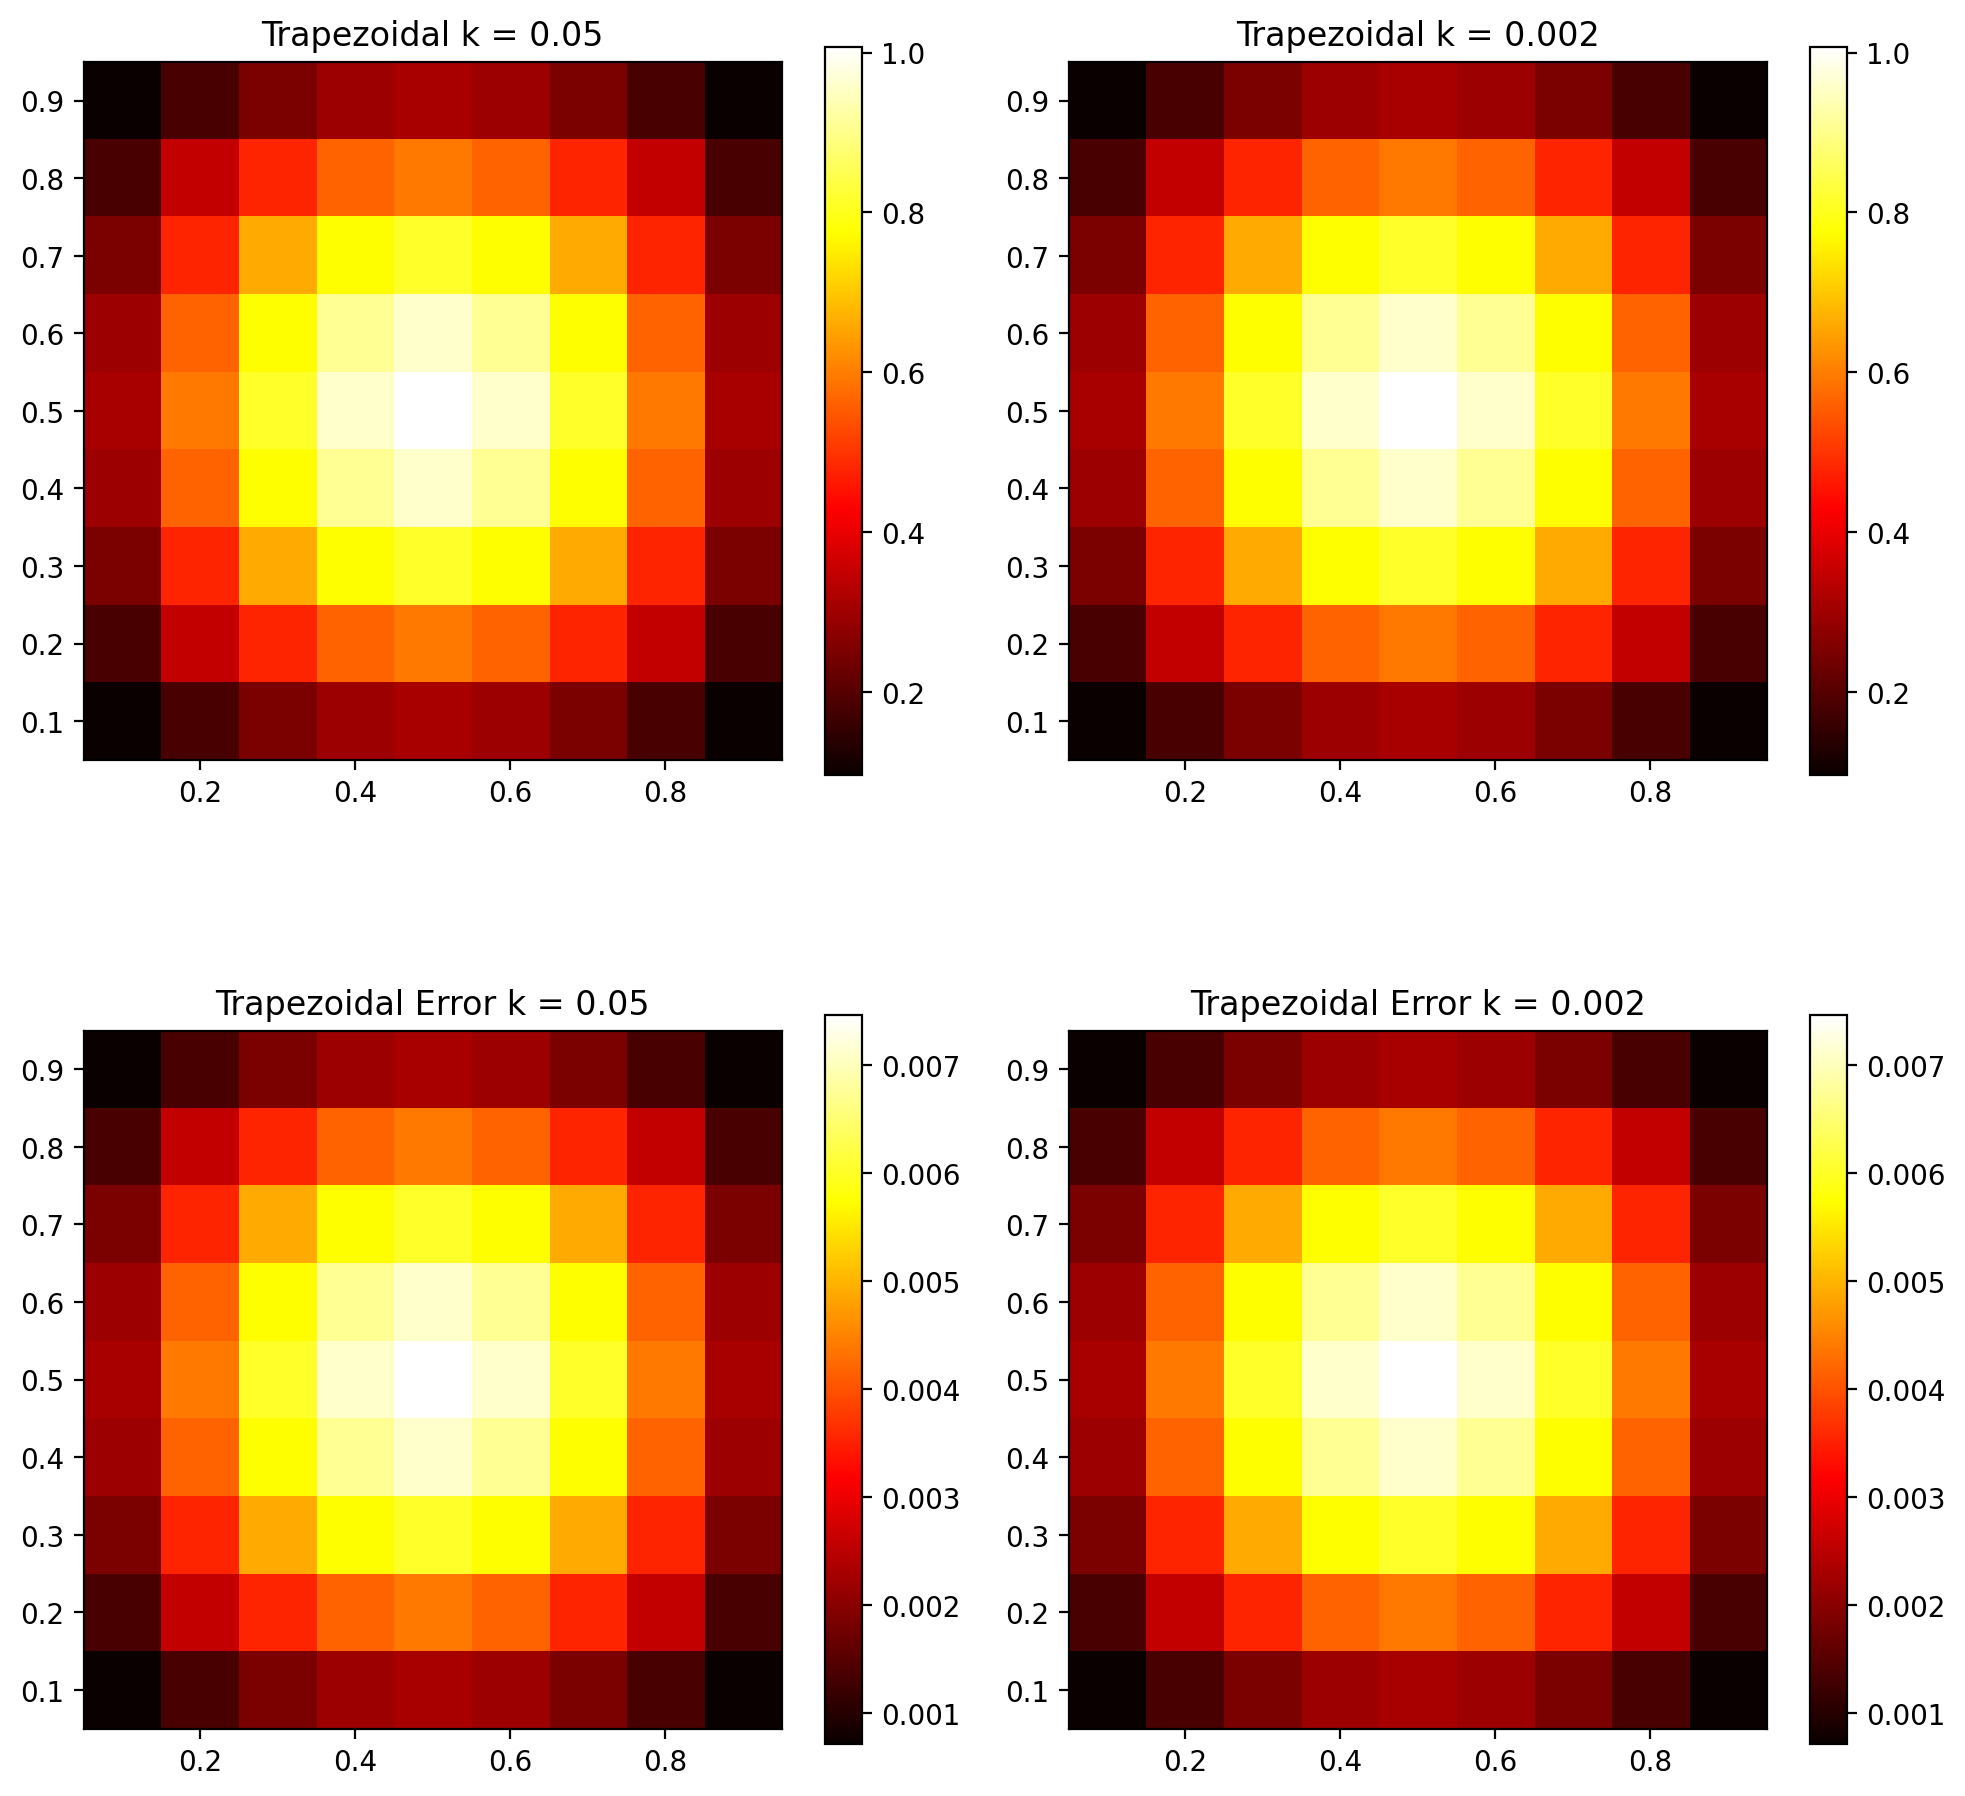

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)

im_coarse = axs[0, 0].imshow(sol_coarse[-1], cmap='hot', interpolation='none', extent=extent, origin='lower')
axs[0, 0].set_title(f'Trapezoidal k = {k_coarse}')
fig.colorbar(axs[0, 0].images[0], ax=axs[0, 0], shrink=0.75)

im_fine = axs[0, 1].imshow(sol_fine[-1], cmap='hot', interpolation='none', extent=extent, origin='lower')
axs[0, 1].set_title(f'Trapezoidal k = {k_fine}')
fig.colorbar(axs[0, 1].images[0], ax=axs[0, 1], shrink=0.75)

axs[1, 0].imshow(grid_error_coarse, cmap='hot', interpolation='none', extent=extent, origin='lower')
axs[1, 0].set_title(f'Trapezoidal Error k = {k_coarse}')
fig.colorbar(axs[1, 0].images[0], ax=axs[1, 0], shrink=0.75)

axs[1, 1].imshow(grid_error_fine, cmap='hot', interpolation='none', extent=extent, origin='lower')
axs[1, 1].set_title(f'Trapezoidal Error k = {k_fine}')
plt.colorbar(axs[1, 1].images[0], ax=axs[1, 1], shrink=0.75)

plt.tight_layout()

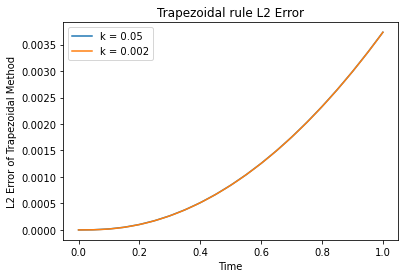

In [33]:
plt.plot(t_eval_coarse, l2_error_coarse, label=f'k = {k_coarse}')
plt.plot(t_eval_fine, l2_error_fine, label=f'k = {k_fine}')
plt.xlabel('Time')
plt.ylabel('L2 Error of Trapezoidal Method')
plt.title('Trapezoidal rule L2 Error')
plt.legend()

## Discussion 
Different from the explicit Euler method, the trapezoidal rule is stable for any $\mu$. Similar to the explicit Euler method, the L-2 norm error grows over time. Both the L-2 norm error and L-infinity norm do not change at all as `k` changes from `.05` to `.002`. It shows that for this problem, error is dominated by the grid spacing `h` rather than the time step `k`.

# Method of lines
In addition I implemented methods of lines(MoL) approach in which time step length is adaptively selected

In [34]:
# solve using Method of lines
_, sol_coarse = solver.solve(time_domain, k_coarse, method='MoL')
l2_error_coarse = solver.calc_error(u)

In [35]:
# calculate error with respect to expected solution 
grid_error_coarse = sol_coarse[-1] - expected_sol

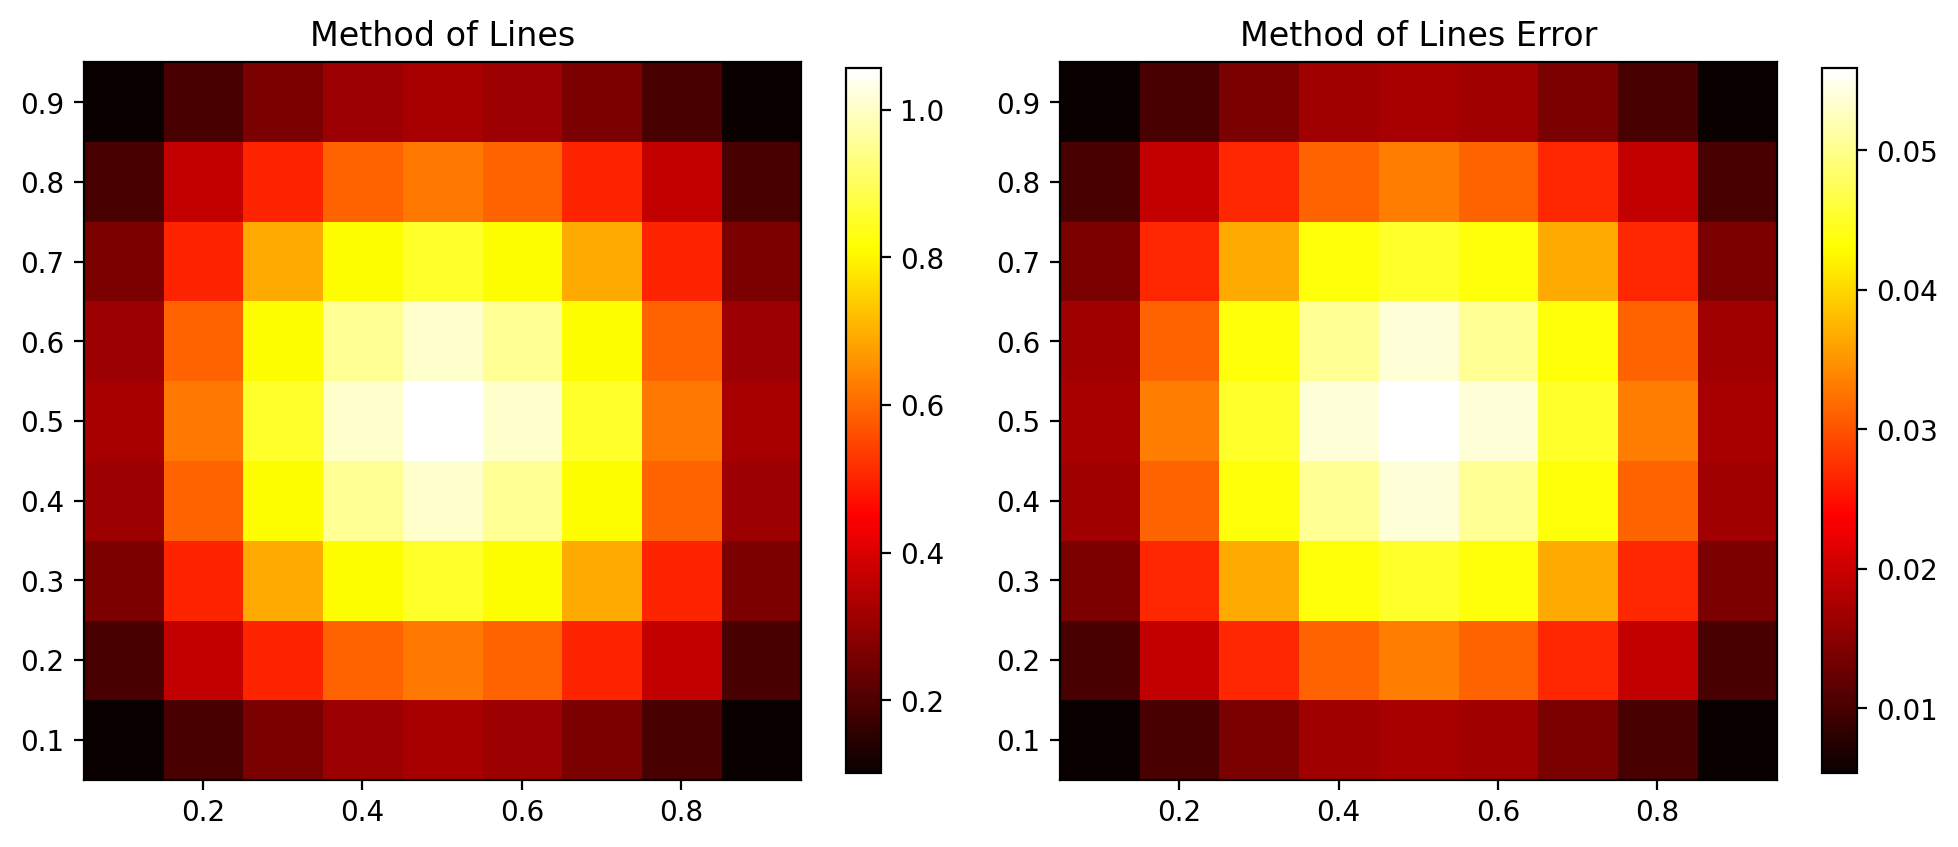

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
axs[0].imshow(sol_coarse[-1], cmap='hot', interpolation='none', extent=extent, origin='lower')
axs[0].set_title(f'Method of Lines')
fig.colorbar(axs[0].images[0], ax=axs[0], shrink=0.75)

axs[1].imshow(grid_error_coarse, cmap='hot', interpolation='none', extent=extent, origin='lower')
axs[1].set_title(f'Method of Lines Error')
fig.colorbar(axs[1].images[0], ax=axs[1], shrink=0.75)

plt.tight_layout()

Text(0.5, 1.0, 'Method of Lines Error')

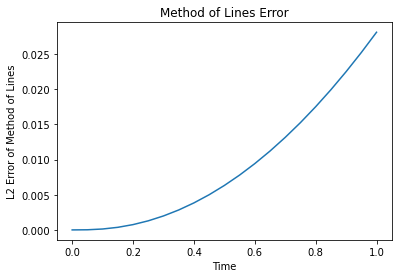

In [37]:
plt.plot(t_eval_coarse, l2_error_coarse, label=f'h = {k_coarse}')
plt.xlabel('Time')
plt.ylabel('L2 Error of Method of Lines')
plt.title('Method of Lines Error')